## Read depth model
Modeled as zero inflated negative binomial distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import betabinom
import numpy as np
from scipy.special import logsumexp
from collections import Counter

from generate_results_python_r.comparison_data_generation import n_cells_list, n_rounds

In [3]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)
coverage = reference.fillna(0) + alternative.fillna(0)
vaf = alternative/(alternative+reference).fillna(0)

In [4]:
def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

# learned from mm34 scRNA seq dataset
mu, theta, pi = 60, 0.17, 0.38
synthetic_data = sample_zinb(mu, theta, pi, size=10000)

We have to deal with a very large proportion of zero read depths

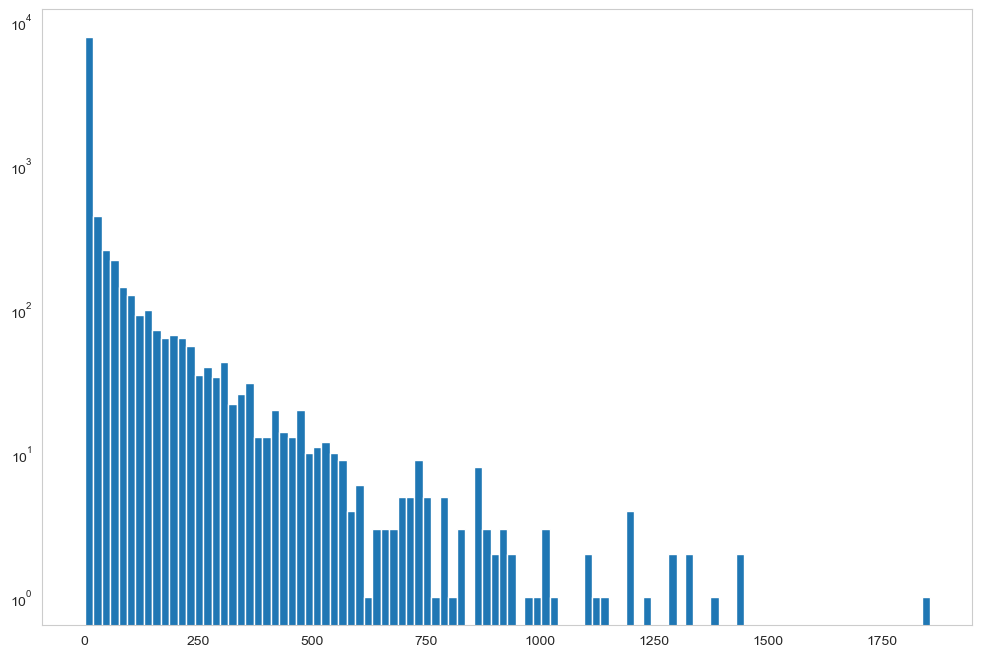

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(synthetic_data, bins=100)
plt.yscale('log')
plt.grid(False)
plt.show()

## VAF simulation

1. Homozygous alternative genotype
2. Homozygous reference genotype
3. Heterozygous genotype

1. Homozygous reference genotype

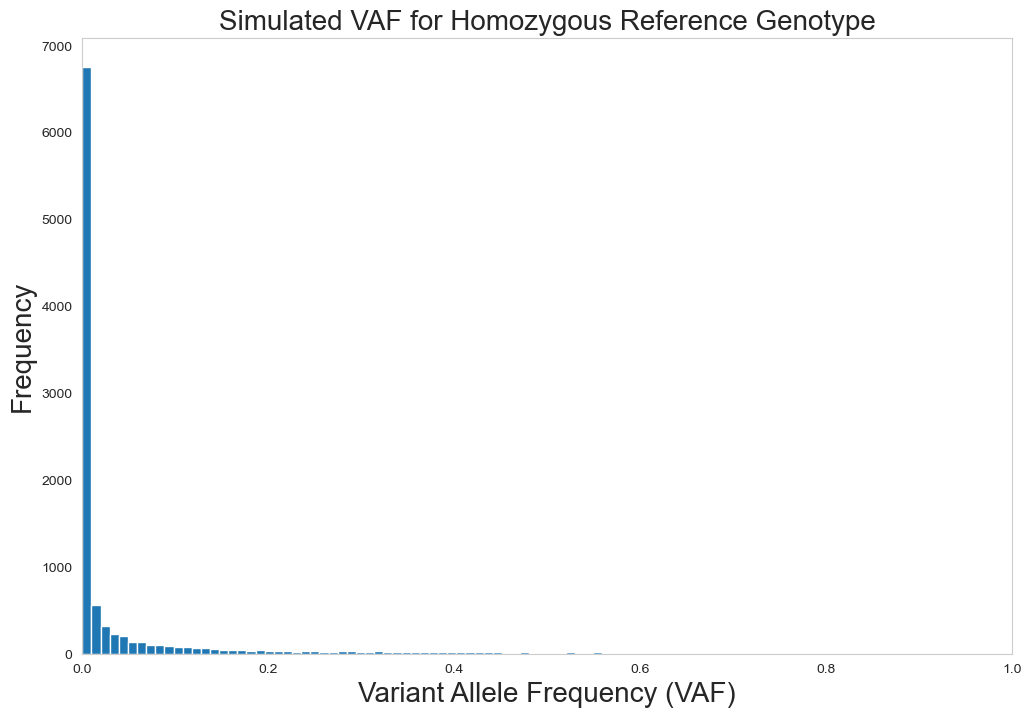

In [6]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = error_rate * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Reference Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

2. Homozygous alternative genotype

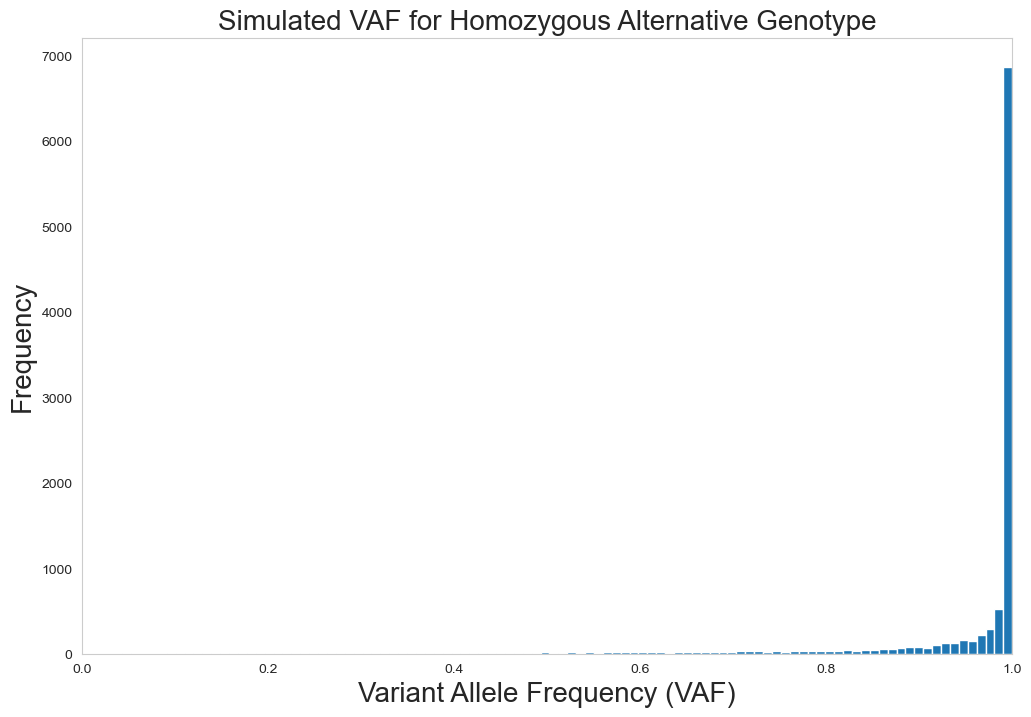

In [7]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

3. Heterozygous genotype

Technical dropout

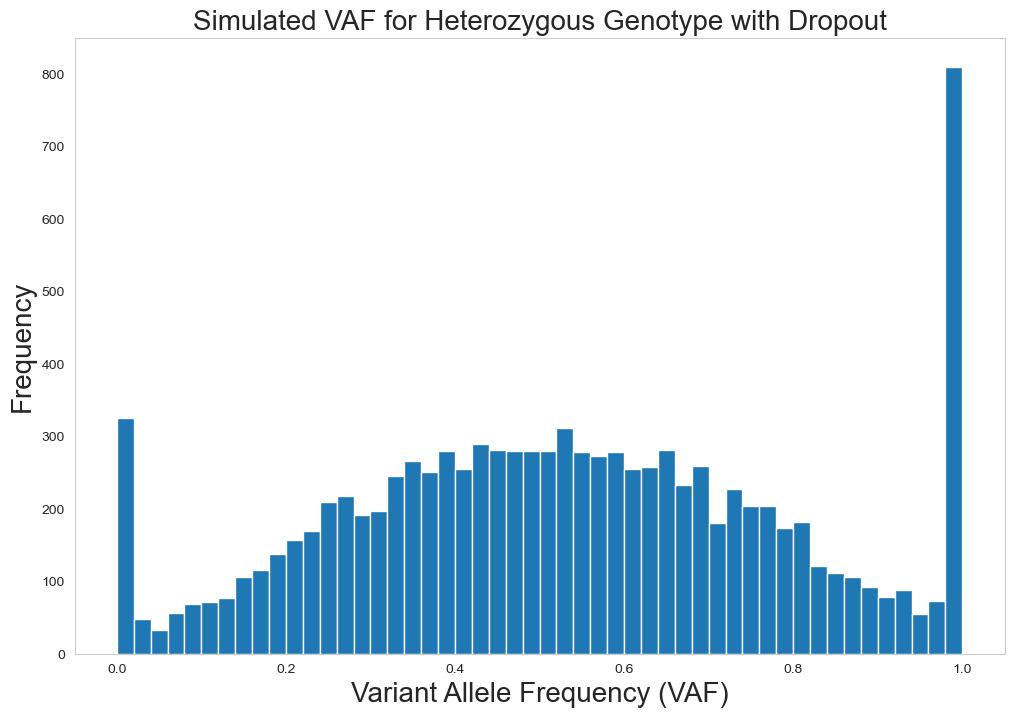

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom, bernoulli

def simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion, dropout_alpha=2, dropout_beta=8, dropout_dir_alpha=4, dropout_dir_beta=4):
    """
    Simulates VAF counts for a heterozygous genotype considering dropout and overdispersion.
    
    Parameters:
    - alpha: Shape parameter of the Beta distribution.
    - beta: Shape parameter of the Beta distribution.
    - dropout_prob: Probability of a technical dropout.
    - dropout_direction_prob: Probability the dropout favors the reference allele.
    - N: Read depth
    - num_simulations: Number of VAF simulations.
    - error_rate: Error rate for monoallelic expressed genes
    - overdispersion: Overdispersion parameter for monoallelic expressed genes
    
    
    Returns:
    - vaf_counts: Array of simulated VAF counts (variant reads).
    """
    vaf_counts = []
    
    for _ in range(num_simulations):
        # Check if a dropout occurs
        
        # dropout_prob = np.random.beta(dropout_alpha, dropout_beta) # samples the dropout rate
        # dropout_direction = np.random.beta(dropout_dir_alpha, dropout_dir_beta) # samples how imbalanced the dropout is between the alleles

        # Determine if dropout occurs
        dropout_occurs = np.random.rand() < dropout_prob

        if dropout_occurs:
            # Determine dropout direction based on sampled probabilities
            dropout_to_A = np.random.rand() < dropout_direction_prob
        
            if dropout_to_A:
                alpha_seq = (1-error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = 0
            else:
                alpha_seq = (error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = N
        
        else:
            # No dropout: use Beta-Binomial distribution to simulate alt reads
            alt_reads = betabinom.rvs(N, alpha, beta)
        
        vaf_counts.append(alt_reads) 
         
    vaf_counts = np.array(vaf_counts)/N
    
    return vaf_counts

# Parameters
alpha = 2.5               # Beta distribution alpha parameter
beta = 2.5               # Beta distribution beta parameter
dropout_prob = 0.15      # Probability of a technical dropout
dropout_direction_prob = 0.7  # Probability dropout favors reference allele
error_rate = 0.05       # Sequencing error rate
overdispersion = 2      # Overdispersion of sequencing errors.
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

# Simulate VAF counts
vaf_counts = simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Simulated VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

Ground Truth Parameters:
f_AA: 0.6000, f_Aa: 0.3000, f_aa: 0.1000
Simulated Read Counts: Counter({'AA': 599, 'Aa': 305, 'aa': 96})

Estimated Parameters:
f_AA: 0.6008, f_Aa: 0.3044, f_aa: 0.0948
Observed Read Counts: Counter({0: 562, 1: 356, 2: 82})


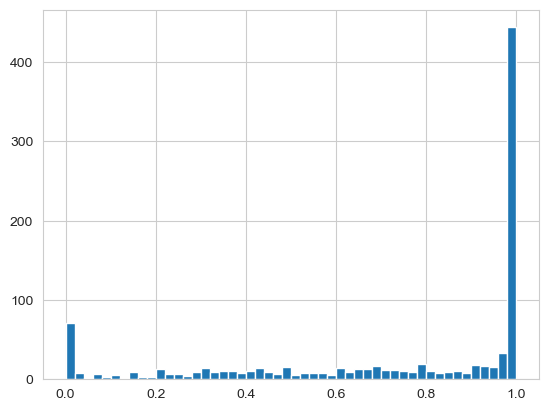

In [9]:
def beta_binomial_params(overdispersion, error_rate, genotype):
    """
    Computes the Beta-Binomial parameters for a given genotype.
    """
    if genotype == "AA":  # Homozygous reference
        alpha = (1 - error_rate) * overdispersion
        beta = overdispersion - alpha
    elif genotype == "aa":  # Homozygous alternative
        alpha = error_rate * overdispersion
        beta = overdispersion - alpha
    return alpha, beta

def genotype_probability(k, N, overdispersion, error_rate, genotype, alpha_h, beta_h):
    """
    Computes the probability of observing `k` alternative reads given genotype.
    """
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    return betabinom.pmf(k, N, alpha, beta)

def e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h):
    """
    E-Step: Computes the responsibilities for each genotype given observations.
    """
    responsibilities = []
    for k, n in zip(k_obs, N):
        # Compute unnormalized posterior probabilities for each genotype
        log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
        log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
        log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
        
        # Use log-sum-exp trick for numerical stability
        log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
        
        # Compute responsibilities
        resp_AA = np.exp(log_p_AA - log_total)
        resp_Aa = np.exp(log_p_Aa - log_total)
        resp_aa = np.exp(log_p_aa - log_total)
        
        responsibilities.append([resp_AA, resp_Aa, resp_aa])
    
    return np.array(responsibilities)

def m_step(responsibilities):
    """
    M-Step: Updates genotype frequencies based on responsibilities.
    """
    f_AA = np.mean(responsibilities[:, 0])
    f_Aa = np.mean(responsibilities[:, 1])
    f_aa = np.mean(responsibilities[:, 2])
    return f_AA, f_Aa, f_aa

def em_algorithm_fixed_params(k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h, min_iterations=10, max_iterations=100, tolerance=1e-6):
    """
    Runs the EM algorithm to estimate genotype proportions with fixed parameters.
    """
    f_AA, f_Aa, f_aa = f_AA_init, f_Aa_init, f_aa_init
    prev_log_likelihood = None
    
    for iteration in range(max_iterations):
        # E-Step
        responsibilities = e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h)
        
        # M-Step
        f_AA, f_Aa, f_aa = m_step(responsibilities)
        
        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for k, n, resp in zip(k_obs, N, responsibilities):
            log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
            log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
            log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
            log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
            log_likelihood += log_total
        
        # Check convergence
        if iteration >= min_iterations:  # Only check convergence after min_iterations
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
                break
        
        prev_log_likelihood = log_likelihood
    
    return f_AA, f_Aa, f_aa, responsibilities

# Parameters
np.random.seed(42)
num_simulations = 1000
overdispersion = 2
error_rate = 0.05
alpha_h, beta_h = 2, 2  # Heterozygous Beta-Binomial parameters
f_AA_true, f_Aa_true, f_aa_true = 0.6, 0.3, 0.1

# Simulate varying read depths
N = np.random.randint(500, 1500, size=num_simulations)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=num_simulations, p=[f_AA_true, f_Aa_true, f_aa_true])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))

# Run EM algorithm with fixed parameters
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3
f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)

# Observed read counts
observed_counts = Counter(np.argmax(responsibilities, axis=1))
total_simulations = sum(observed_counts.values())

# Results
print("Ground Truth Parameters:")
print(f"f_AA: {f_AA_true:.4f}, f_Aa: {f_Aa_true:.4f}, f_aa: {f_aa_true:.4f}")
print(f"Simulated Read Counts: {read_counts}")
print("\nEstimated Parameters:")
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")
print(f"Observed Read Counts: {observed_counts}")

plt.hist(k_obs/N, bins=50)
plt.show()

f_AA: 0.5084, f_Aa: 0.1861, f_aa: 0.3055


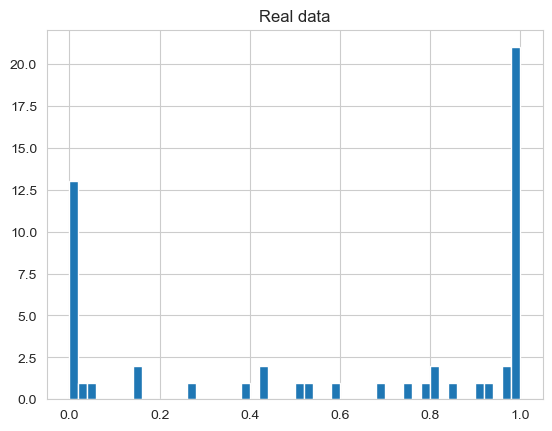

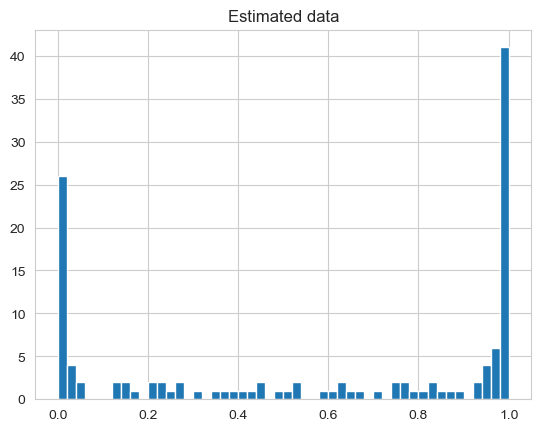

In [10]:
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3

non_zero_indices = np.where(coverage.iloc[:, 0] > 0)[0]
N_nonzero = np.array(coverage)[:, 0][non_zero_indices]
k_obs_nonzero = np.array(alternative)[:, 0][non_zero_indices]

f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs_nonzero, N_nonzero, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")

n_cells = 127
N = np.random.randint(500, 1500, size=n_cells)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=n_cells, p=[f_AA_est, f_Aa_est, f_aa_est])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))
    
plt.hist(vaf.iloc[:, 0], bins=50)
plt.title("Real data")
plt.show()

plt.hist(k_obs/N, bins=50)
plt.title("Estimated data")
plt.show()

In [3]:
# for i in tqdm(range(n_samples)):
#     alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
#     ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
#     genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
#     alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
#     betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
#     
#     for snv in range(alt.shape[1]): 
#         vaf = alt[:, snv]/(alt[:, snv]+ref[:, snv])
#         if "H" in list(np.unique(genotype_gt[:, snv])):
#             ind = np.where(genotype_gt[:, snv] == "H")
#             vaf = vaf[ind]
#             if len(vaf) > 50:
#                 plt.title(f"{alphas_H_gt[snv]} and {betas_H_gt[snv]}")
#                 plt.hist(vaf, bins=20)
#                 plt.show()

In [21]:
import os
import numpy as np

base_path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data - Kopie"

n_cells_list = [100, 100, 50]
n_mut_list = [50, 100, 100]
n_clones_list = [5, 10, 20, ""]

n_samples = 100
n_rounds = 3

all_vaf_errors = []

all_overdispersions_gt = []
all_overdispersions = []

all_dropout_probs_gt = []
all_dropout_probs = []

for clone in n_clones_list:
    for (n_cells, n_mut) in zip(n_cells_list, n_mut_list):
        path_gt = os.path.join(base_path,  f"{n_cells}c{n_mut}m{clone}")
        path = os.path.join(base_path, f"{n_cells}c{n_mut}m{clone}", "sciterna")

        sample_vaf_errors = []
        for i in range(n_samples):
            genotype = np.loadtxt(os.path.join(path_gt, "genotype", f"genotype_{i}.txt"), dtype=str)
            overdispersions_h = np.loadtxt(os.path.join(path_gt, "overdispersions_H", f"overdispersions_H_{i}.txt"), dtype=float)
            dropout_probs = np.loadtxt(os.path.join(path_gt, "dropout_probs", f"dropout_probs_{i}.txt"), dtype=float)

            round_vaf_errors = []
            for r in range(n_rounds):
                sciterna_individual_dropout_probs = np.loadtxt(os.path.join(path, f"sciterna_individual_dropout_probs/sciterna_individual_dropout_probs_{r}r{i}.txt"), dtype=float).T
                sciterna_individual_overdispersions_h = np.loadtxt(os.path.join(path, f"sciterna_individual_overdispersions_H/sciterna_individual_overdispersions_H_{r}r{i}.txt"), dtype=float)
                sciterna_global_parameters = np.loadtxt(os.path.join(path, f"sciterna_global_parameters/sciterna_global_parameters_{r}r{i}.txt"))
                sciterna_genotype = np.loadtxt(os.path.join(path, f"sciterna_genotype/sciterna_genotype_{r}r{i}.txt"), dtype=str)

                differences_genotype = np.where(genotype != sciterna_genotype, 1, 0)
                vaf_error = np.sum(differences_genotype)/(n_cells*n_mut)
                round_vaf_errors.append(vaf_error)

                all_overdispersions.extend(sciterna_individual_overdispersions_h)
                all_overdispersions_gt.extend(overdispersions_h)

                all_dropout_probs.extend(sciterna_individual_dropout_probs)
                all_dropout_probs_gt.extend(dropout_probs)
            sample_vaf_errors.append(round_vaf_errors)
        all_vaf_errors.append(sample_vaf_errors)

In [7]:
np.mean(np.array(all_vaf_errors), axis=(0,1))

array([0.07782283, 0.07741217, 0.07760292])

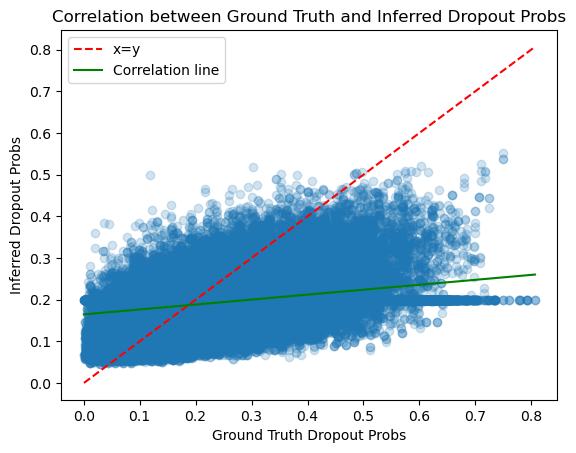

In [22]:
x = np.array(all_dropout_probs_gt)
y = np.array(all_dropout_probs)

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

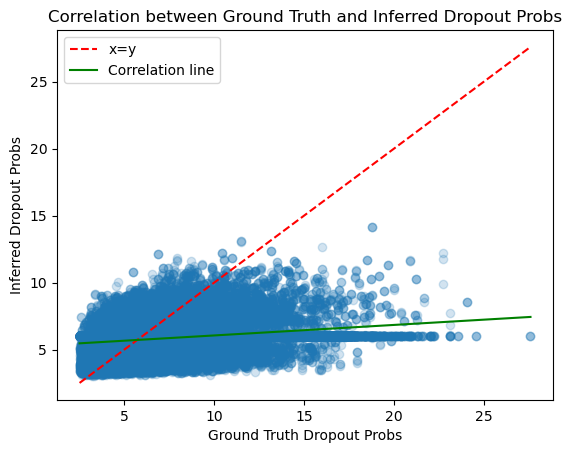

In [19]:
import matplotlib.pyplot as plt

x = np.array(all_overdispersions_gt)
y = np.array(all_overdispersions)

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

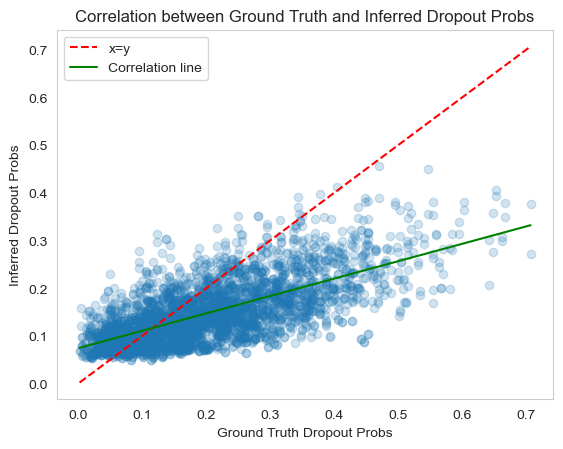

In [15]:
keep_indices = np.array([i for i in range(total_rounds*n_samples) if i % total_rounds != 0])
h_counts = np.sum(np.array(all_individual_genotypes)[keep_indices,0] == "H", axis=1)
mask = h_counts > 50
indices = mask.flatten()
x = np.array(all_individual_params)[keep_indices, 1].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 0].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

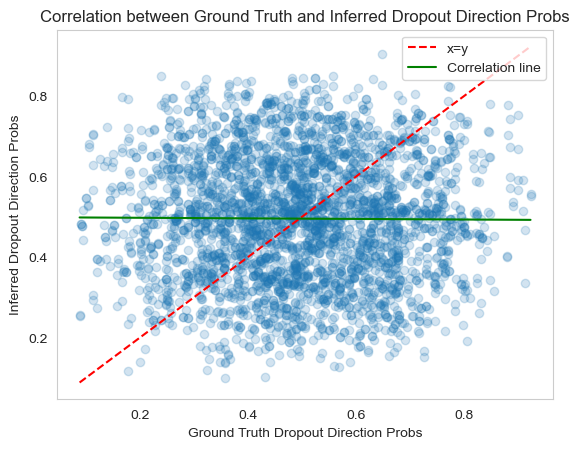

In [16]:
x = np.array(all_individual_params)[keep_indices, 3].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 2].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Direction Probs")
plt.ylabel("Inferred Dropout Direction Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Direction Probs")
plt.legend()
plt.show()

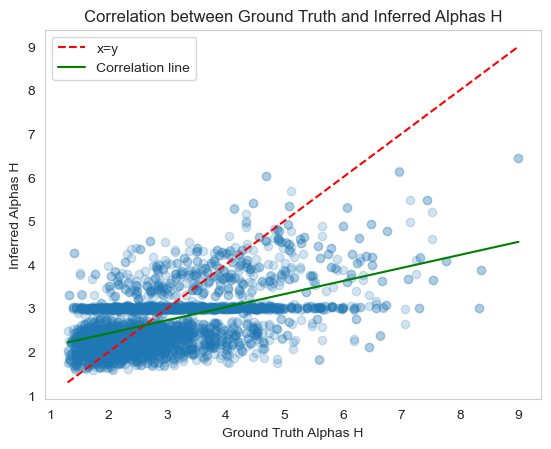

In [17]:
x_alpha = np.array(all_individual_params)[keep_indices, 5].flatten()[indices] # gt
y_alpha = np.array(all_individual_params)[keep_indices, 4].flatten()[indices] # predicted

plt.scatter(x_alpha, y_alpha, alpha=0.2)
lims = [min(x_alpha.min(), y_alpha.min()), max(x_alpha.max(), y_alpha.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_alpha, y_alpha, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Alphas H")
plt.ylabel("Inferred Alphas H")
plt.title("Correlation between Ground Truth and Inferred Alphas H")
plt.legend()
plt.show()

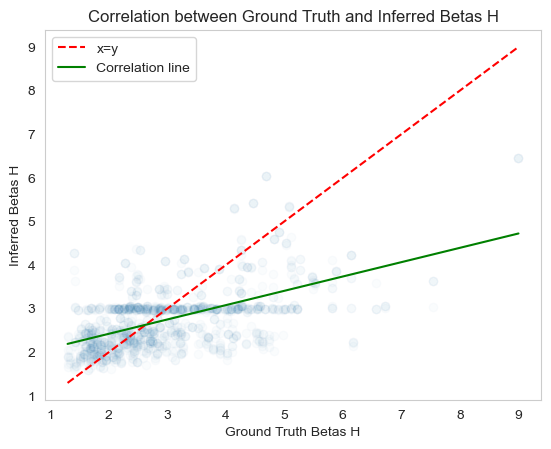

In [6]:
x_beta = np.array(all_individual_params)[keep_indices, 7].flatten()[indices] # gt
y_beta = np.array(all_individual_params)[keep_indices, 6].flatten()[indices] # predicted

plt.scatter(x_beta, y_beta, alpha=0.02)
lims = [min(x_beta.min(), y_beta.min()), max(x_beta.max(), y_beta.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_beta, y_beta, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Betas H")
plt.ylabel("Inferred Betas H")
plt.title("Correlation between Ground Truth and Inferred Betas H")
plt.legend()
plt.show()

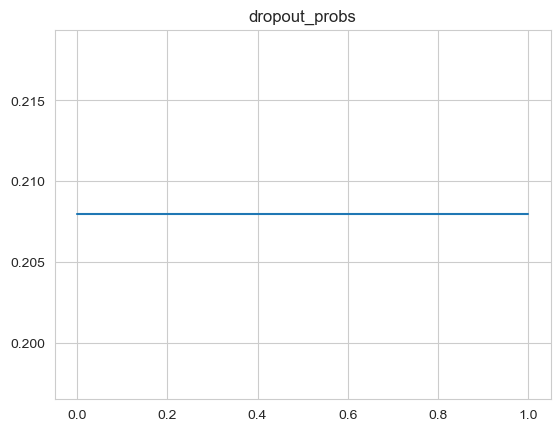

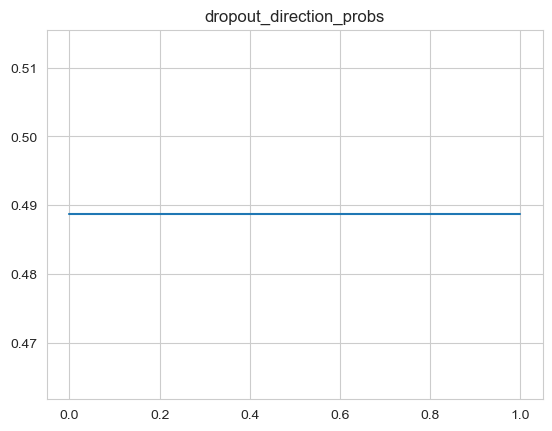

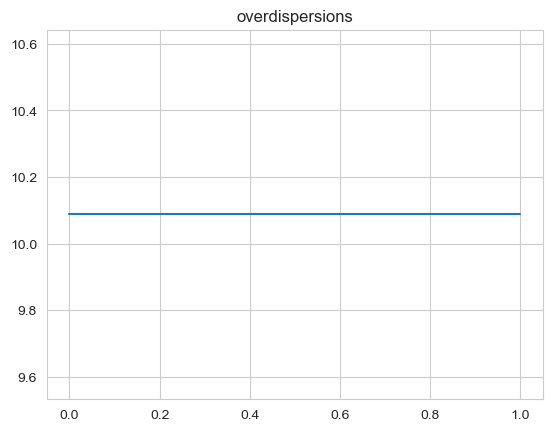

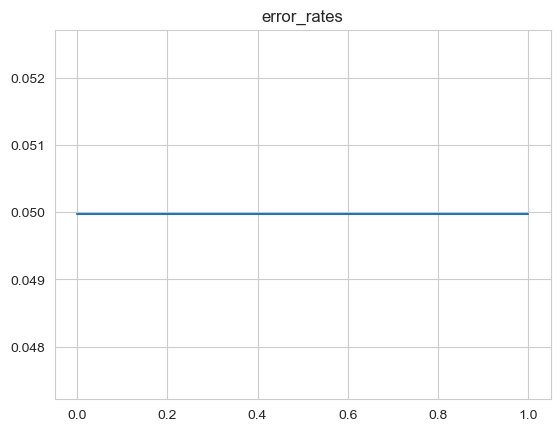

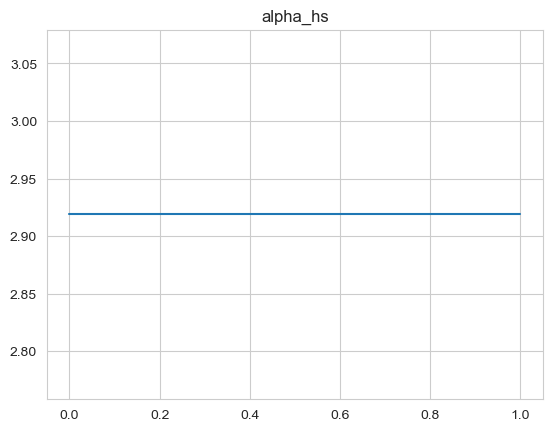

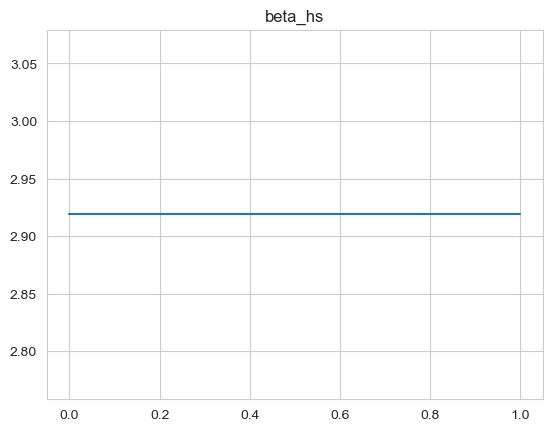

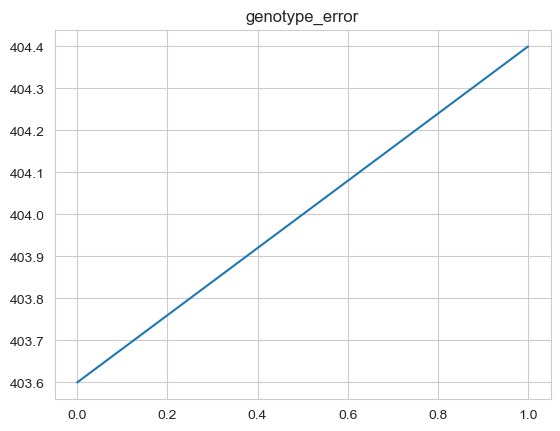

In [13]:
param = ["dropout_probs", "dropout_direction_probs", "overdispersions", "error_rates", "alpha_hs", "beta_hs", "genotype_error"]
for i in range(len(np.mean(all_params, axis=0)[0])):
    plt.title(param[i])
    plt.plot(np.mean(np.array(all_params), axis=0)[:,i])
    plt.show()

In [12]:
def genotype_confusion_matrix(genotype, genotype_gt):
    unique_genotypes = ["R", "H", "A"]
    confusion_counts = {g: {other: 0 for other in unique_genotypes} for g in unique_genotypes}

    for true, pred in zip(genotype_gt.flatten(), genotype.flatten()):
        if true != pred:
            confusion_counts[true][pred] += 1  # Count how often true genotype is mistaken for pred

    # Print results
    print("Replacements:")
    for true, counts in confusion_counts.items():
        for pred, count in counts.items():
            if true != pred:  # Only show misclassifications
                print(f"{true} → {pred}: {count}")

genotype_confusion_matrix(genotype_gt, genotype)

Replacements:
R → H: 217
R → A: 383
H → R: 278
H → A: 112
A → R: 769
A → H: 971


In [11]:
i=2
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c50m"

alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
params = mf.update_parameters(np.array(ref), np.array(alt), np.array(genotype_gt))
dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = params

optimized:  23226.52048298504
ground truth:  23242.62323439122
Global parameters: [ 0.22689196  0.46977098 10.10182335  0.05121476  5.33750334]
